In [91]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings 
warnings.filterwarnings("ignore")

In [92]:
#Selecting part of the data because dataset is extremely large and shows memory issues

nrows = 10000
dataset = pd.read_excel('Online Retail.xlsx', nrows = 100000)     #excel
dataset.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [93]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    100000 non-null  object        
 1   StockCode    100000 non-null  object        
 2   Description  99701 non-null   object        
 3   Quantity     100000 non-null  int64         
 4   InvoiceDate  100000 non-null  datetime64[ns]
 5   UnitPrice    100000 non-null  float64       
 6   CustomerID   65085 non-null   float64       
 7   Country      100000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 6.1+ MB


In [94]:
#Check how many missing values per column
dataset.isnull().sum()

InvoiceNo          0
StockCode          0
Description      299
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     34915
Country            0
dtype: int64

In [95]:
#Missing values of customer ID must be dropped to create a user matrix later

dataset.dropna(subset=['CustomerID'], inplace=True)

I don't need to drop the description because the items will be identified by the stock code

# Recommendation system

In [96]:
#I need to convert customer ID into string for consistency when creating the matrix
dataset['CustomerID'] = dataset['CustomerID'].astype(str)

In [97]:
#Identifying the values that are greater than 0 to identify the interest of the consumer
dataset = dataset[(dataset['Quantity'] > 0) & (dataset['UnitPrice'] > 0)]

In [98]:
#Creating pivot table for the user matrix

user_item_matrix = dataset.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)

In [99]:
user_item_matrix.head()

StockCode,10002,10120,10125,10133,10135,11001,15034,15036,15039,16008,...,90214J,90214K,90214M,90214R,90214S,90214V,BANK CHARGES,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
#Creating the user similarity matrix
user_similarity = cosine_similarity(user_item_matrix)

#displaying the data in a dataframe
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [101]:
#Rating prediction using the matrices for user collaboration
def predict_ratings_user_based(user_item_matrix, user_similarity):
    mean_user_rating = user_item_matrix.mean(axis=1).values
    ratings_diff = (user_item_matrix.values - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T
    return pred

#Predicting the ratings 
user_predicted_ratings = predict_ratings_user_based(user_item_matrix, user_similarity)

In [102]:
#Evaluation of the model
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

print("User-User Collaborative Filtering RMSE:", rmse(user_predicted_ratings, user_item_matrix.values))

User-User Collaborative Filtering RMSE: 58.6225346276051


In [13]:
#Creating item similarity matrix
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)


In [14]:
#Rating prediction using the matrices for item collaboration
def predict_ratings_item_based(user_item_matrix, item_similarity):
    pred = user_item_matrix.values.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
    return pred

#Predicting the ratings 
item_predicted_ratings = predict_ratings_item_based(user_item_matrix, item_similarity)


In [15]:
#Evaluation of the model
print("Item-Item Collaborative Filtering RMSE:", rmse(item_predicted_ratings, user_item_matrix.values))

Item-Item Collaborative Filtering RMSE: 53.0596728448166


In both cases, for item and user collaboration, the errors are still quite high. I will try to normalize the data and apply singular value decomposition to try to increase the accuracy of the recommendation system: https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/


In [16]:
from scipy.sparse.linalg import svds

In [17]:
#Normalizing the data for the user matrix
user_ratings_mean = np.mean(user_item_matrix.values, axis=1)
ratings_demeaned = user_item_matrix.values - user_ratings_mean.reshape(-1, 1)

In [18]:
#Singular Value Decomposition
U, sigma, Vt = svds(ratings_demeaned, k=50)
sigma = np.diag(sigma)

In [19]:
#Rating prediction
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns=user_item_matrix.columns)

In [20]:
#Evaluation of the model 
print("SVD Collaborative Filtering RMSE:", rmse(predicted_ratings_df.values, user_item_matrix.values))

SVD Collaborative Filtering RMSE: 16.55023014055252


With this procedure it is possible to see a significant improvement. It shows that the prediction on the articles will differ by 7 products approximately. With this last method, the system is considering the latent factors and the significant patterns in terms of users' itemds preferences. 

With this approach, I will proceed to create the recommendation for a customer.

In [21]:
#Getting the top recommendations for a given user --> starting with 5 recommendations
def recommend_items(user_id, user_item_matrix, predicted_ratings_df, num_recommendations=5):
    user_idx = user_item_matrix.index.get_loc(user_id) #Sort the user's predicted ratings
    sorted_user_ratings = predicted_ratings_df.iloc[user_idx].sort_values(ascending=False)
    user_data = user_item_matrix.loc[user_id] #merging user data with the sorted predicted ratings
    user_full = (user_data[user_data > 0]).sort_values(ascending=False)
    recommendations = sorted_user_ratings[~sorted_user_ratings.index.isin(user_full.index)]
    return recommendations.head(num_recommendations) #Recommendation of items that the user did not buy yet

In [22]:
#Finding the recommendation for a random user
random_user_index = np.random.choice(user_item_matrix.index)# I select a random user

recommendations = recommend_items(random_user_index, user_item_matrix, predicted_ratings_df, num_recommendations=5)

In [23]:
customer_id = random_user_index

In [24]:
print("Recommendations for customer ID:", customer_id)
print(recommendations)

Recommendations for customer ID: 16730.0
StockCode
21982    15.962165
70006     7.681826
17021     6.797326
21981     5.705424
21977     3.303144
Name: 1163, dtype: float64


In [25]:
#Displaying the results in a dataframe
probabilities = { #results of the system recommendation in probability
    '22629': 0.431998,
    '22579': 0.369833,
    '22594': 0.360364,
    '22326': 0.346135,
    '22818': 0.343138
}

In [26]:
#Converting data into string to match the description
dataset['StockCode'] = dataset['StockCode'].astype(str)

In [27]:
stock_codes = ['22629', '22579', '22594', '22326', '22818'] #here the results of the system

In [28]:
filtered_data = dataset[dataset['StockCode'].isin(['22629', '22579', '22594', '22326', '22818'])] #filtering the stock codes
filtered_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
34,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,2010-12-01 08:45:00,2.95,12583.0,France
35,536370,22629,SPACEBOY LUNCH BOX,24,2010-12-01 08:45:00,1.95,12583.0,France
543,536412,22326,ROUND SNACK BOXES SET OF4 WOODLAND,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
550,536412,22629,SPACEBOY LUNCH BOX,1,2010-12-01 11:49:00,1.95,17920.0,United Kingdom
644,536415,22594,CHRISTMAS GINGHAM TREE,5,2010-12-01 11:57:00,0.85,12838.0,United Kingdom
...,...,...,...,...,...,...,...,...
96821,544586,22326,ROUND SNACK BOXES SET OF4 WOODLAND,3,2011-02-21 15:04:00,2.95,17338.0,United Kingdom
97475,544634,22326,ROUND SNACK BOXES SET OF4 WOODLAND,2,2011-02-22 11:02:00,2.95,17994.0,United Kingdom
97583,544645,22629,SPACEBOY LUNCH BOX,12,2011-02-22 11:58:00,1.95,16843.0,United Kingdom
98135,544670,22326,ROUND SNACK BOXES SET OF4 WOODLAND,2,2011-02-22 15:22:00,2.95,16161.0,United Kingdom


In [29]:
prob_df = pd.DataFrame(list(probabilities.items()), columns=['StockCode', 'Probability']) #creating df with the results and the stockcode


In [30]:
#Merge the results and the description
final_result_df = pd.merge(filtered_data[['StockCode', 'Description']].drop_duplicates(), prob_df, on='StockCode')

final_result_df 

,StockCode,Description,Probability
0,22326,ROUND SNACK BOXES SET OF4 WOODLAND,0.346135
1,22629,SPACEBOY LUNCH BOX,0.431998
2,22594,CHRISTMAS GINGHAM TREE,0.360364
3,22579,WOODEN TREE CHRISTMAS SCANDINAVIAN,0.369833
4,22818,CARD CHRISTMAS VILLAGE,0.343138


The above items would be recommended to this client, with a probability for them to buy them that is stated in the column "Probability"

# Time series 

In [32]:
#Reading again the dataset to parse it by dates
dataset = pd.read_excel('Online Retail.xlsx',
                 index_col = 'InvoiceDate',
                 parse_dates = True)
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


#### WHAT WOULD BE THE COLUMNS FOR MY INTEREST FI I AM WORKING FOR TIME SERIES? Quantity and Price (money)

In [33]:
#Selecting the columns of interest
data_subset = dataset[['Quantity', 'UnitPrice']]

In [34]:
#Aggregating the data by date / day
df_daily = data_subset.resample('D').agg({'Quantity': 'sum', 'UnitPrice': 'mean'})    #D it means daily, there are monday-friday, monthly, and another (check on library)
                                                #why use the average? arima use the average model, an average will be hepping me where we are standing, and if will be usefull or not

In [35]:
#Missing values
df_daily.fillna(method='ffill', inplace=True)  #ffill = which one will be the optimal metric to fill in the missing values.

In [36]:
#Verify the data
df_daily.head()

,Quantity,UnitPrice
InvoiceDate,,
2010-12-01,26814,4.151947
2010-12-02,21023,3.231712
2010-12-03,14830,5.047271
2010-12-04,0,5.047271
2010-12-05,16395,2.896576


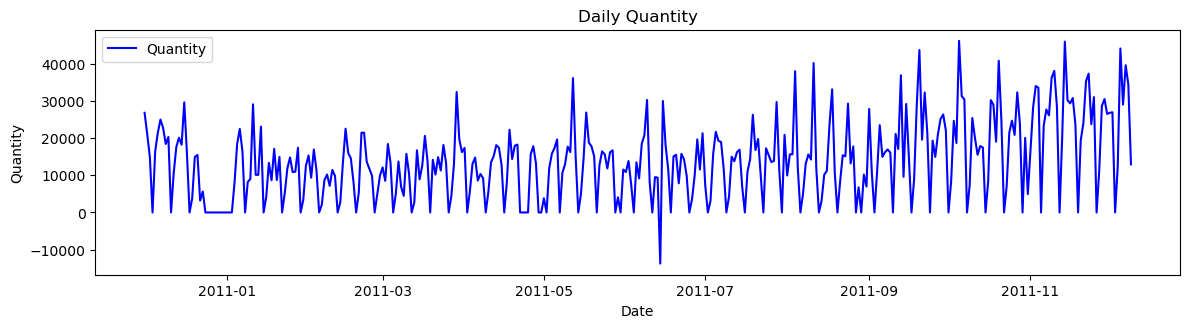

In [37]:
#Plotting the time series data to see the trends: Quantity
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df_daily['Quantity'], label='Quantity', color='blue')
plt.title('Daily Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

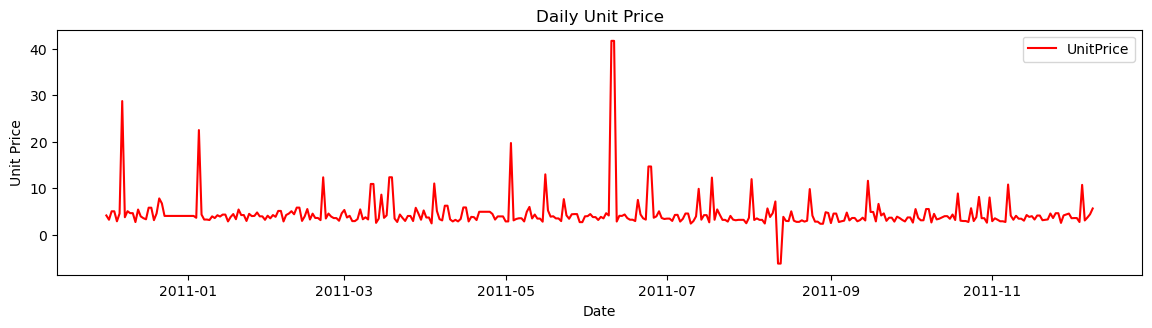

In [38]:
#Plotting the time series data to see the trends: Price
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
plt.plot(df_daily['UnitPrice'], label='UnitPrice', color='red')
plt.title('Daily Unit Price')
plt.xlabel('Date')
plt.ylabel('Unit Price')
plt.legend()

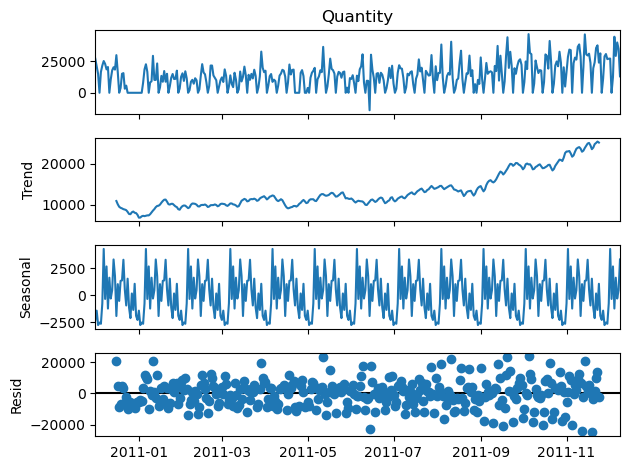

In [39]:
#Decomposing Quantity
decomposition_quantity = seasonal_decompose(df_daily['Quantity'], model='additive', period=30)
decomposition_quantity.plot()
plt.show()

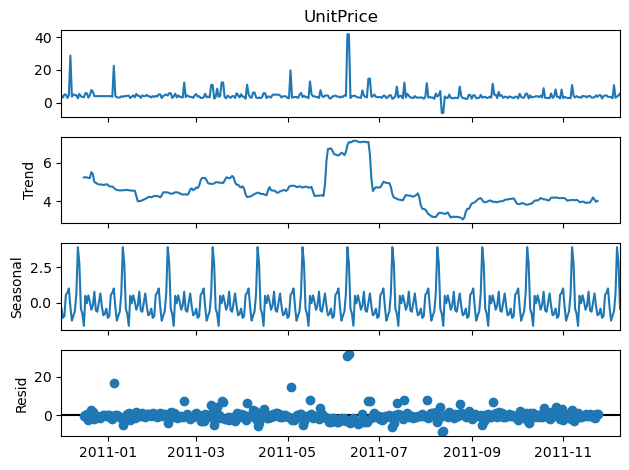

In [40]:
# Decomposing Price
decomposition_price = seasonal_decompose(df_daily['UnitPrice'], model='additive', period=30)
decomposition_price.plot()
plt.show()

In [41]:
# Applying Ducky Fuller test to see the seasonality of the data: Quantity

#H0: data is not seasonal      > we accepted the hypothesis as p_value is higher than alpha 38% then we have to apply ARIMA
#H1: data is seasonal

result_quantity = adfuller(df_daily['Quantity'])
print('p-value for Quantity:', result_quantity[1])

p-value for Quantity: 0.3829872594133546


As p-value is greater than alpha (0.05), I accept the null hypothesis. Then, the data is not seasonal. When data is not seasonal, the appropriate model would be ARIMA for Quantity

# ARIMA: Quantity

In [42]:
train_size = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]    #:train_size = the beggining until the train or train_size: = until the end

In [43]:
order_quantity = (1, 1, 1)             # first stage;  2 steps behind of the history 
model_quantity = ARIMA(train['Quantity'], order=order_quantity)

In [44]:
#Training the model
results_quantity = model_quantity.fit()
results_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Quantity   No. Observations:                  299
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3118.273
Date:                Wed, 07 Aug 2024   AIC                           6242.545
Time:                        20:47:20   BIC                           6253.636
Sample:                    12-01-2010   HQIC                          6246.985
                         - 09-25-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2713      0.061      4.418      0.000       0.151       0.392
ma.L1         -0.9825      0.016    -62.423      0.000      -1.013      -0.952
sigma2      7.128e+07   6.63e-11   1.08e+18      0.000    7.13e+07    7.13e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                11.30
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+35. Standard errors may be unstable.
"""

In [ ]:
# model used: ARIMA
# improtant info: Sample 12-01-2010 - 09-25-2011
# skew (distorcao) = if the data is skew for one side or another one
# sigma = standard deviation of my variable

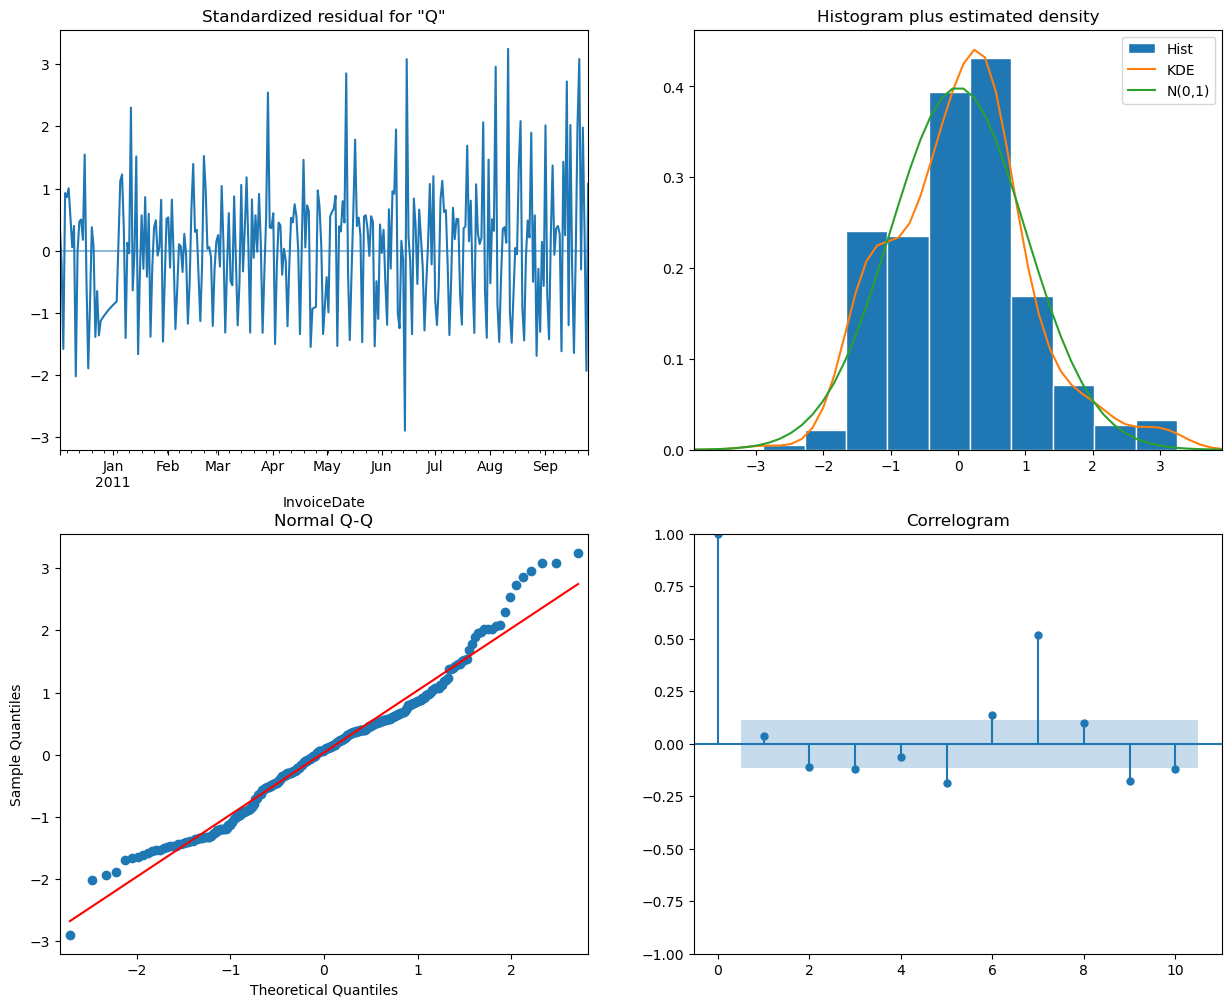

In [45]:
#Diagnostic
results_quantity.plot_diagnostics(figsize=(15, 12))
plt.show()                                                  #checking just the Quantity 

In [46]:
#Forecast for the next 10 days
forecast_steps_quantity = 10 
forecast_quantity = results_quantity.get_forecast(steps=forecast_steps_quantity)
forecast_ci_quantity = forecast_quantity.conf_int()

In [47]:
#Results in a table
forecast_df_quantity = pd.DataFrame({
    'Forecast': forecast_quantity.predicted_mean.round(), # Whole number as quantitative 
})
forecast_df_quantity       #how much I expect to seel?

,Forecast
2011-09-26,15663.0
2011-09-27,14669.0
2011-09-28,14399.0
2011-09-29,14326.0
2011-09-30,14306.0
2011-10-01,14301.0
2011-10-02,14299.0
2011-10-03,14299.0
2011-10-04,14299.0
2011-10-05,14299.0


In [48]:
#Confidence intervals in a table 
forecast_ci_quantity = pd.DataFrame({
    'Lower CI': forecast_ci_quantity.iloc[:, 0].round(),#Whole number
    'Upper CI': forecast_ci_quantity.iloc[:, 1].round(),#Whole number 
})
forecast_ci_quantity

# it doesn't looks good the result, becasue we are forecasting negative numbers.

,Lower CI,Upper CI
2011-09-26,-884.0,32211.0
2011-09-27,-2555.0,31893.0
2011-09-28,-2898.0,31696.0
2011-09-29,-2986.0,31638.0
2011-09-30,-3013.0,31625.0
2011-10-01,-3023.0,31624.0
2011-10-02,-3029.0,31627.0
2011-10-03,-3034.0,31632.0
2011-10-04,-3039.0,31636.0
2011-10-05,-3044.0,31641.0


In [49]:
#Forecast for the test period
forecast_steps = len(test)
forecast_quantity = results_quantity.get_forecast(steps=forecast_steps)
forecast_values = forecast_quantity.predicted_mean.round()
forecast_values.index = test.index

In [50]:
#Accuracy check
mae = mean_absolute_error(test['Quantity'], forecast_values).round()
mae

12582.0

In [51]:
mse = mean_squared_error(test['Quantity'], forecast_values).round()
mse

207204916.0

In [52]:
rmse = np.sqrt(mse).round()
rmse

14395.0

In [53]:
mape = np.mean(np.abs((test['Quantity'] - forecast_values) / test['Quantity'])) * 100
mape     #mean absolute percentage error
                                    # result = in = infinite

inf

In [54]:
#Apparenlty there is a zero in the division, I will try to fix it --> This suggestions comes from ChatGPT

# to avoit the infinite error, the suggestions is devide everything that doesn't have zero on the dominator.

non_zero_test = test['Quantity'] != 0
filtered_test = test['Quantity'][non_zero_test]
filtered_forecast = forecast_values[non_zero_test]

In [55]:
#Recalculating MAPE
mape = np.mean(np.abs((filtered_test - filtered_forecast) / filtered_test)) * 100
print(f'MAPE: {mape:.2f}%')

# 47% of the time the predictions are wrong.

MAPE: 47.94%


The accuracy of this model is low to make it a trustable result. Beding MAPE 47.9% indicates that there is an error 47% of the times that there is a prediction. I plot the model, to detect the discrepancies. 

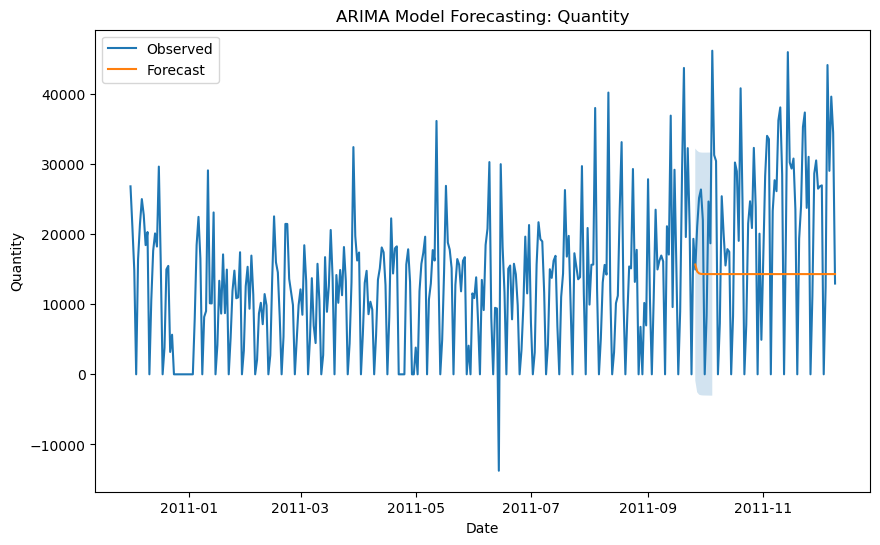

In [56]:
#Visualising forecasting: Quantity
plt.figure(figsize=(10, 6))
plt.plot(df_daily.index, df_daily['Quantity'], label='Observed')
plt.plot(forecast_quantity.predicted_mean.index, forecast_quantity.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci_quantity.index, forecast_ci_quantity.iloc[:, 0], forecast_ci_quantity.iloc[:, 1], alpha=0.2)
plt.title('ARIMA Model Forecasting: Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

In [ ]:
# result it doesnt looks good, the yellos and red line are very bad and doesnt follow the trend.
# ARIMA model dont work very well

In [57]:
#Forecasting for the next 20 days
forecast_steps_days_quantity = 20
forecast_quantity_second = results_quantity.get_forecast(steps=forecast_steps_days_quantity)
forecast_ci_quantity_second = forecast_quantity_second.conf_int()

In [58]:
#Results in a table
forecast_df_quantity_second = pd.DataFrame({
    'Forecast': forecast_quantity_second.predicted_mean.round(), # Whole number as quantitative 
})
forecast_df_quantity_second

# not really good with ARIMA model, almost equals

,Forecast
2011-09-26,15663.0
2011-09-27,14669.0
2011-09-28,14399.0
2011-09-29,14326.0
2011-09-30,14306.0
2011-10-01,14301.0
2011-10-02,14299.0
2011-10-03,14299.0
2011-10-04,14299.0
2011-10-05,14299.0


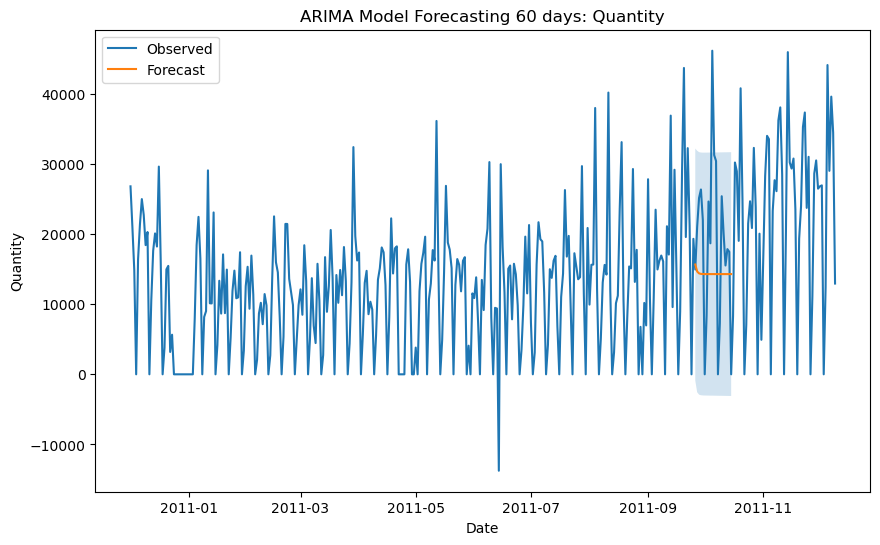

In [59]:
#Visualising forecasting for 60 days: Quantity
plt.figure(figsize=(10, 6))
plt.plot(df_daily.index, df_daily['Quantity'], label='Observed')
plt.plot(forecast_quantity_second.predicted_mean.index, forecast_quantity_second.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci_quantity_second.index, forecast_ci_quantity_second.iloc[:, 0], forecast_ci_quantity_second.iloc[:, 1], alpha=0.2)
plt.title('ARIMA Model Forecasting 60 days: Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

The model seems to need a greater exploration.

In [ ]:
# result it doesnt looks good, the yellos and red line are very bad and doesnt follow the trend.
# ARIMA model dont work very well

In [60]:
#Differencing Quantity                   #working with the differences now(remeber 9-4=5 from the slides?those differences)

df_daily['Quantity_diff'] = df_daily['Quantity'].diff().dropna()

#Rechecking stationarity after differencing

#H0: data is not seasonal
#H1: data is seasonal

result_quantity_diff = adfuller(df_daily['Quantity_diff'].dropna())
print('ADF Statistic for Differenced Quantity:', result_quantity_diff[0])
print('p-value for Differenced Quantity:', result_quantity_diff[1])

# 10 zeros before the 1. we reject the Hypothesis. the data is seasonal then. if is seasonal has to be used SARIMAX

ADF Statistic for Differenced Quantity: -7.232499776107928
p-value for Differenced Quantity: 1.977878769852039e-10


Now, with these values, the data can be considered seasonal

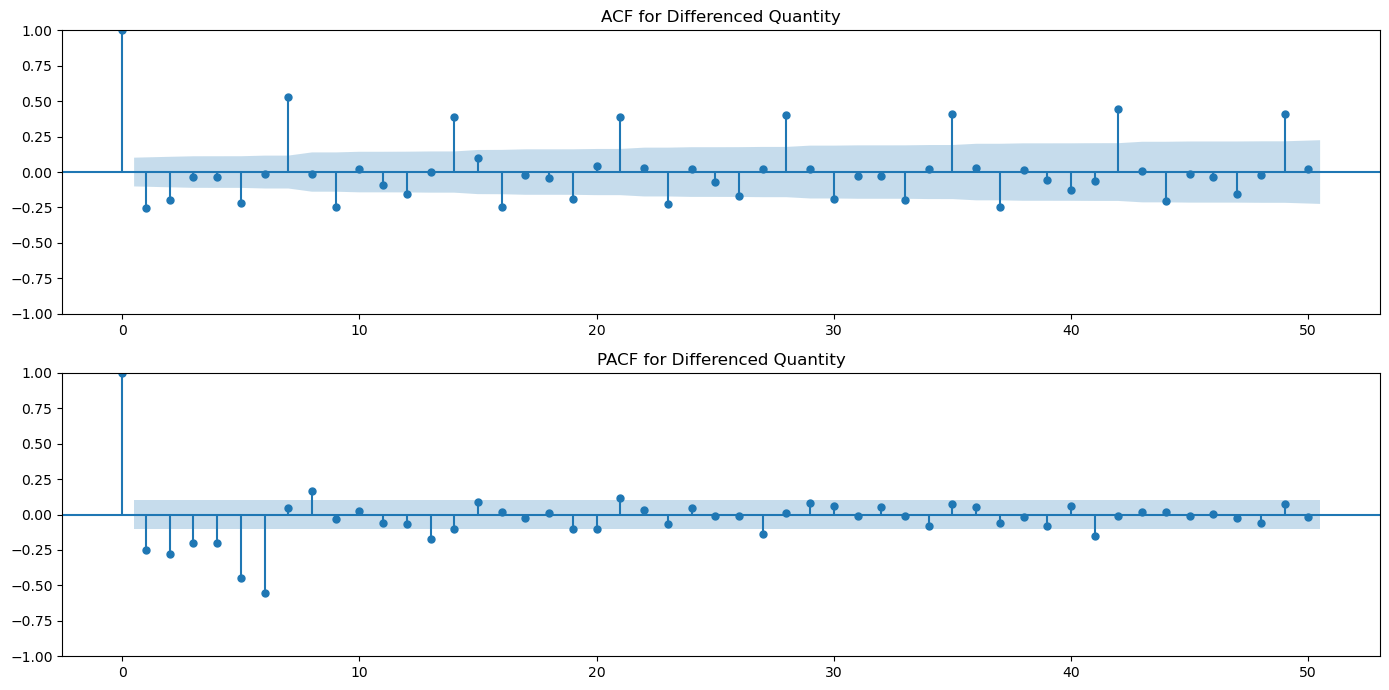

In [61]:
#ACF and PACF plots for differenced quantity
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plot_acf(df_daily['Quantity_diff'].dropna(), ax=plt.gca(), lags=50)
plt.title('ACF for Differenced Quantity')
plt.subplot(2, 1, 2)
plot_pacf(df_daily['Quantity_diff'].dropna(), ax=plt.gca(), lags=50)
plt.title('PACF for Differenced Quantity')
plt.tight_layout()
plt.show()

With this data, I can conduct a SARIMAX model for Quantity

In [ ]:
############working with SARIMAX then now:

In [62]:
#Fitting SARIMAX model on training data for 30 days (monthly)
order = (1, 1, 1) 
seasonal_order = (1, 1, 1, 30)  # I want to see those 3 periods + 30, (30 it means 30 days)

In [63]:
model = SARIMAX(train['Quantity'], order=order, seasonal_order=seasonal_order)
results = model.fit()

In [64]:
#Model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Quantity   No. Observations:                  299
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -2828.084
Date:                            Wed, 07 Aug 2024   AIC                           5666.169
Time:                                    20:47:33   BIC                           5684.124
Sample:                                12-01-2010   HQIC                          5673.380
                                     - 09-25-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2738      0.059      4.609      0.000       0.157       0.390
ma.L1         -1.0000      2.856     -0.350      0.726      -6.597       4.597
ar.S.L30      -0.1505      0.096     -1.562      0.118      -0.339       0.038
ma.S.L30      -0.9947      2.916     -0.341      0.733      -6.709       4.720
sigma2      6.874e+07    4.2e-08   1.63e+15      0.000    6.87e+07    6.87e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.63   Prob(JB):                         0.11
Heteroskedasticity (H):               1.73   Skew:                             0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.78e+32. Standard errors may be unstable.
"""

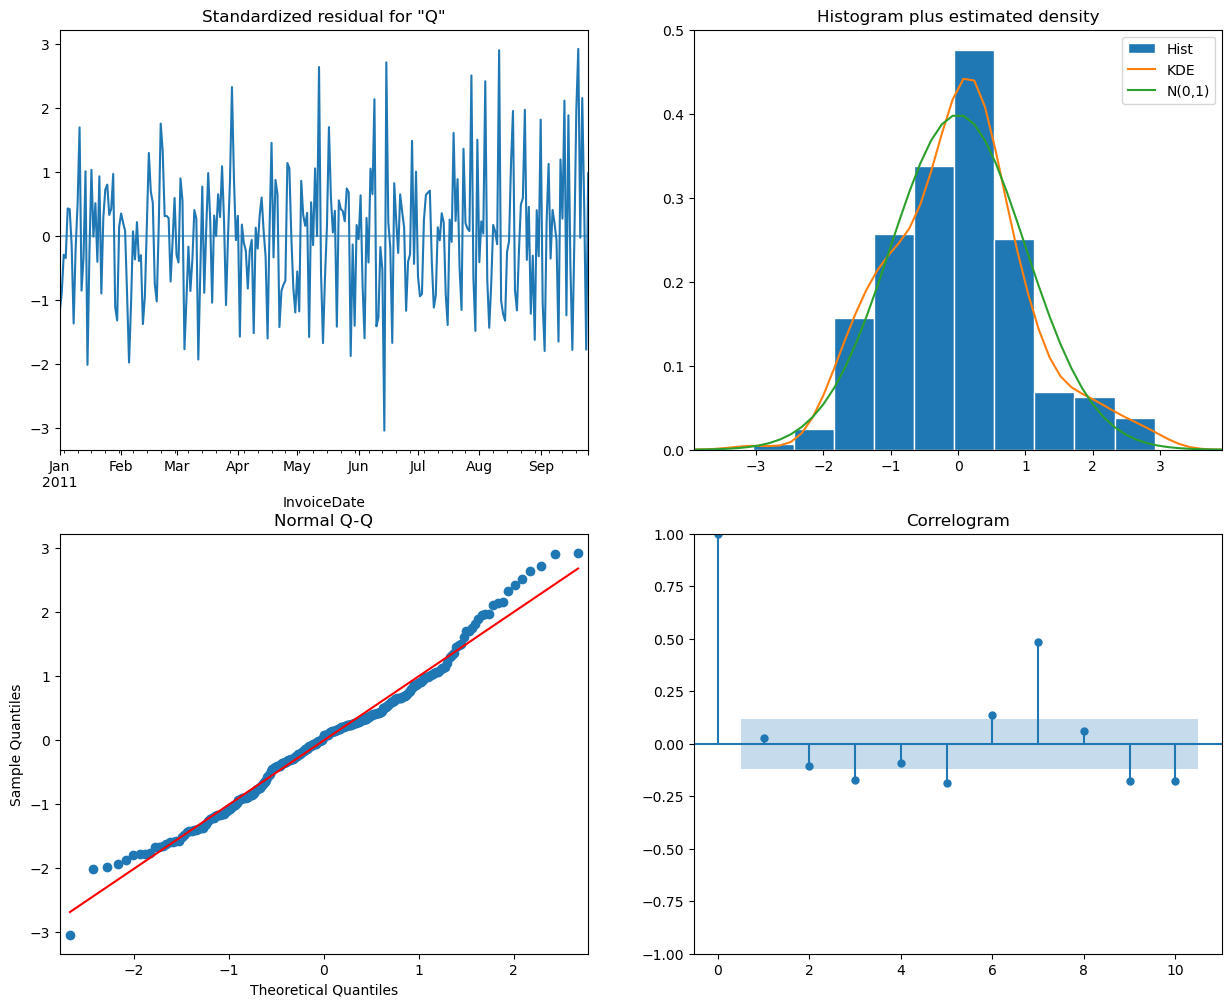

In [65]:
#Diagnostic
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
#very similar than the previously with Quantity applying the ARIMA, but it seems a bit better.

In [66]:
#Forecasting for the test period
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean.round()
forecast_values.index = test.index

In [67]:
#Accuracy
mae = mean_absolute_error(test['Quantity'], forecast_values).round()
mae

11941.0

In [68]:
mse = mean_squared_error(test['Quantity'], forecast_values).round()
mse

188710310.0

In [69]:
rmse = np.sqrt(mse).round()
rmse

13737.0

In [70]:
#In case there are zeros in the division as before
non_zero_test = test['Quantity'] != 0
filtered_test = test['Quantity'][non_zero_test]
filtered_forecast = forecast_values[non_zero_test]

mape = np.mean((np.abs((filtered_test - filtered_forecast) / filtered_test)) * 100).round()
mape

# 47% not very well

47.0

In [71]:
# Results of forecasting in table
forecast_df_quantity = pd.DataFrame({
    'Forecast': forecast.predicted_mean.round(),
})
print(forecast_df_quantity)

            Forecast
2011-09-26   15505.0
2011-09-27   13902.0
2011-09-28   15586.0
2011-09-29   14032.0
2011-09-30   11661.0
...              ...
2011-12-05   16989.0
2011-12-06   15995.0
2011-12-07   17501.0
2011-12-08   18555.0
2011-12-09   19420.0

[75 rows x 1 columns]


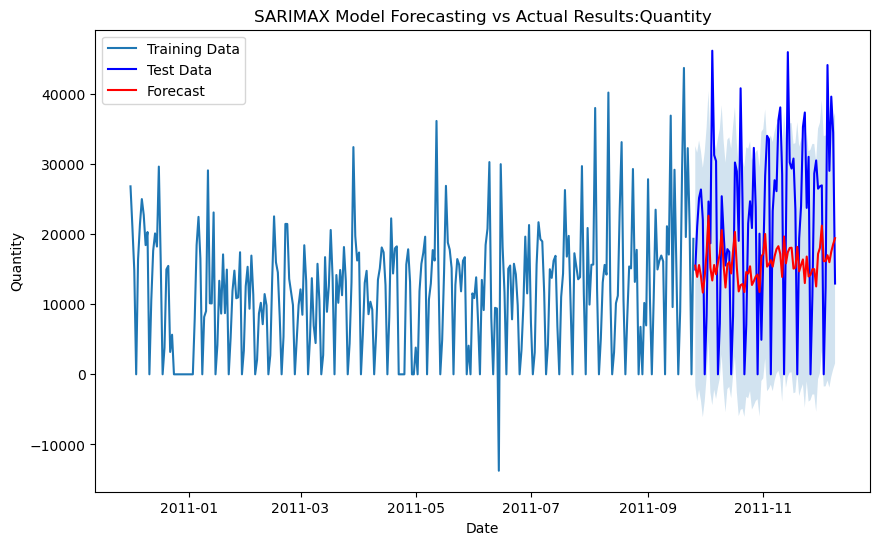

In [72]:
# Comparing actual model with the forecasting
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Quantity'], label='Training Data')
plt.plot(test.index, test['Quantity'], label='Test Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast.conf_int().index, 
                 forecast.conf_int().iloc[:, 0].round(), 
                 forecast.conf_int().iloc[:, 1].round(), alpha=0.2)
plt.title('SARIMAX Model Forecasting vs Actual Results:Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

In [ ]:
#blues = testing data     red = forecasting
#not very good, but better than the previous one where was jsut a straight line
#may be the data has many noise, outliers, could be the reason of not be perfect

The forecast results are in red, showing some differences from the actual data, but following the same pattern

# SARIMAX: Price

In [73]:
# Applying Ducky Fuller test to see the seasonality of the data: Unit Price

#H0: data is not seasonal
#H1: data is seasonal

result_price = adfuller(df_daily['UnitPrice'])
print('p-value for Price:', result_price[1])

p-value for Price: 4.826043204961929e-25


In this case p-value is much smaller than alpha, so, data is seasonal for the price we reject the Hypothesis. I can apply SARIMAX here right away.

In [74]:
#Splitting the data into training and test set
train_size = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

In [75]:
#Training the model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 30) #monthly seasonality frequency of 30 days

In [76]:
model = SARIMAX(train['UnitPrice'], order=order, seasonal_order=seasonal_order)    #applying for PRICE
results = model.fit()

In [77]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          UnitPrice   No. Observations:                  299
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood                -796.492
Date:                            Wed, 07 Aug 2024   AIC                           1602.985
Time:                                    20:47:39   BIC                           1620.940
Sample:                                12-01-2010   HQIC                          1610.196
                                     - 09-25-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2702      0.027      9.912      0.000       0.217       0.324
ma.L1         -0.9943      0.072    -13.717      0.000      -1.136      -0.852
ar.S.L30      -0.0649      0.073     -0.887      0.375      -0.208       0.078
ma.S.L30      -0.9878      1.359     -0.727      0.467      -3.652       1.676
sigma2        16.8648     22.147      0.762      0.446     -26.542      60.272
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):              7840.13
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             2.92
Prob(H) (two-sided):                  0.06   Kurtosis:                        28.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

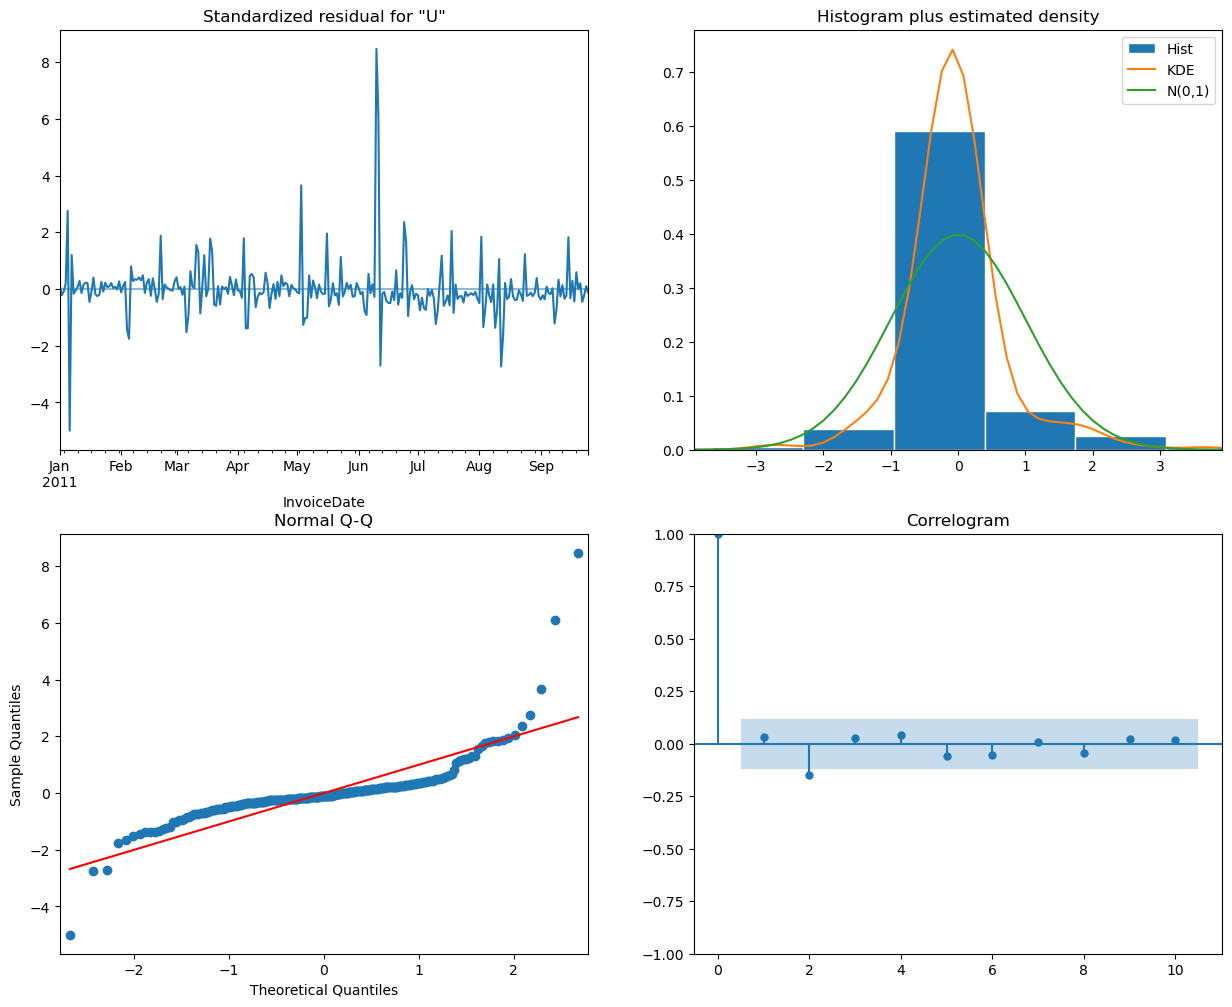

In [78]:
#Diagnostic
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# for the price one, the Histogram doesnt looks good, there are few elasticity and the tables doesnt have too much claricity, even the lines are not very clear about normal distribution.

# the last grphs is good, is show us that the point are around the line, with one execption(the first line)

In [79]:
#Forecasting on the test period
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_values.index = test.index

In [80]:
#Avoiding zeros in the denominator

non_zero_test = test['UnitPrice'] != 0
filtered_test = test['UnitPrice'][non_zero_test]
filtered_forecast = forecast_values[non_zero_test]

mape = np.mean(np.abs((filtered_test - filtered_forecast) / filtered_test)) * 100
mape

#33% much better than previous one.

33.490462958217854

In [81]:
#Results in a table
forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
})
print(forecast_df)

            Forecast
2011-09-26  3.154368
2011-09-27  3.292245
2011-09-28  2.978020
2011-09-29  3.171716
2011-09-30  4.974681
...              ...
2011-12-05  3.448568
2011-12-06  4.604903
2011-12-07  7.261040
2011-12-08  7.182985
2011-12-09  3.407464

[75 rows x 1 columns]


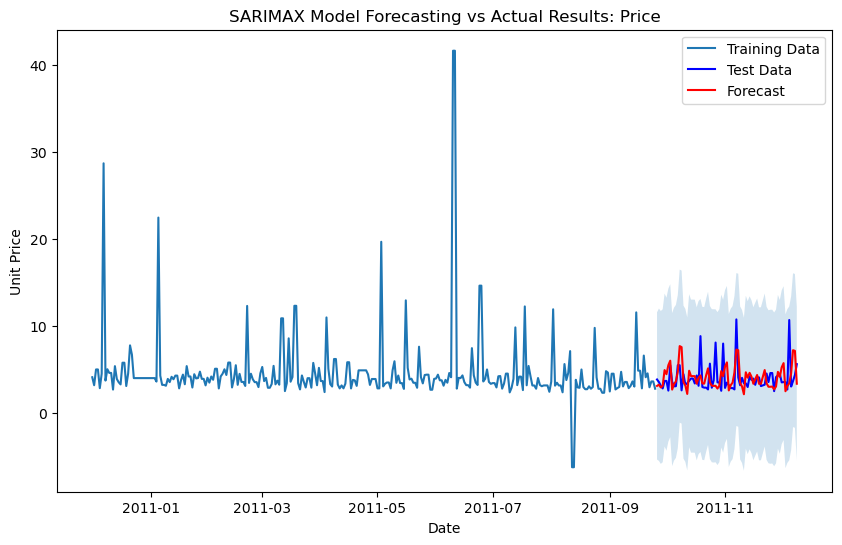

In [82]:
#Comparing actual results with forecasting values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['UnitPrice'], label='Training Data')
plt.plot(test.index, test['UnitPrice'], label='Test Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast.conf_int().index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], alpha=0.2)
plt.title('SARIMAX Model Forecasting vs Actual Results: Price')
plt.xlabel('Date')
plt.ylabel('Unit Price')
plt.legend()
plt.show()

In [ ]:
# the forecast cap the trend, very nice graph!

The results shown in red above are aligned and very close to the real results. For this model, MAPE indicates that there are errors in approximately 30% of the predictions, so there is a 70% accuracy in this model.

In [83]:
#Forecasting for the next 10 days: Fit the model with the full dataset
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 30)
model = SARIMAX(df_daily['UnitPrice'], order=order, seasonal_order=seasonal_order)
results = model.fit()

In [84]:
#Defining the time period
forecast_steps = 10          #can be change for 20 days, 30 days etc
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [85]:
#Future dates for the forecast
last_date = df_daily.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

In [86]:
#Results in a table for confidence intervals and forecasting
forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
}, index=future_dates)

In [87]:
forecast_df

,Forecast,Lower CI,Upper CI
2011-12-10,3.575734,-4.025692,11.177160
2011-12-11,2.372300,-5.482780,10.227379
2011-12-12,4.524971,-3.349774,12.399717
2011-12-13,3.965935,-3.911014,11.842884
2011-12-14,4.488489,-3.388841,12.365819
2011-12-15,4.024125,-3.853290,11.901541
2011-12-16,3.390727,-4.486711,11.268164
2011-12-17,3.731929,-4.145514,11.609372
2011-12-18,4.691463,-3.185982,12.568909
2011-12-19,3.268007,-4.609440,11.145454


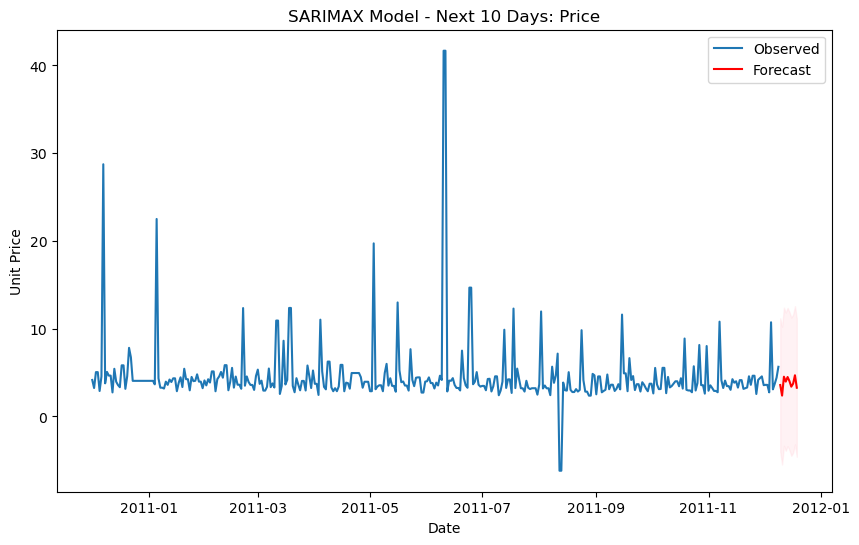

In [88]:
#Results in a visualisation:forecasting
plt.figure(figsize=(10, 6))
plt.plot(df_daily.index, df_daily['UnitPrice'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower CI'], 
                 forecast_df['Upper CI'], color='pink', alpha=0.2)
plt.title('SARIMAX Model - Next 10 Days: Price')
plt.xlabel('Date')
plt.ylabel('Unit Price')
plt.legend()
plt.show()

In [ ]:
# In resume: we cna do Forecasting with the Price, but with Quantity we can do but not trusth as the error and 
# forecasting are not very good.